**São Paulo**

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [124]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [125]:
city = 'São Paulo'
words = ['são paulo','sao paulo','sampa','paulista','paulistano','dória','doria','covas','prefeito','governador','covas','prefeitura']
#df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'}, 'text': re.compile('|'.join(words), re.IGNORECASE),'city':city,'score': {'$ne':None}, 'polarity': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))
df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'}, 'text': re.compile('|'.join(words), re.IGNORECASE),'city':city,'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [126]:
len(df)

635

In [127]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-10 12:25:32,user_location,São Paulo,São Paulo,RT @joh_barbosaa: @getuliosantana @hoje_no O p...,-0.1027,pt
1,2020-02-13 13:39:28,user_location,São Paulo,São Paulo,RT @teleunifesp: O Telessaúde São Paulo promov...,0.3400,pt
2,2020-02-13 18:16:33,user_location,São Paulo,São Paulo,"RT @SamParkerSenate: 21. ""Sam, you sound like ...",-0.8172,en
3,2020-02-17 22:51:07,user_location,São Paulo,São Paulo,Renato augusto e Paulinho venham agora para o ...,0.0000,pt
4,2020-02-22 22:46:04,user_location,São Paulo,São Paulo,"RT @aagulla_espn: Confirmado, 3 partidos suspe...",-0.4767,es


In [128]:
df.to_excel(city+'.xlsx')

Média total de sentimentos - Vader

In [129]:
df['score'].describe()

count    635.000000
mean      -0.083176
std        0.447748
min       -0.957100
25%       -0.437200
50%        0.000000
75%        0.316700
max        0.974700
Name: score, dtype: float64

Média total de sentimentos - SenticNet

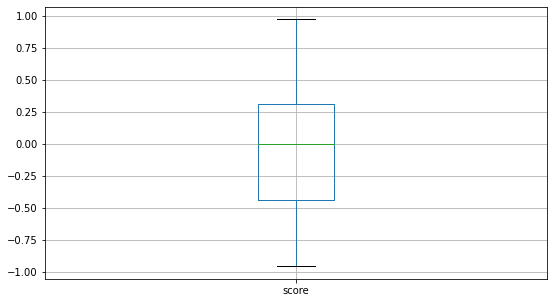

In [130]:
boxplot = df.boxplot(column=['score'], grid=True, figsize=(9, 5))

Funções auxiliares

In [131]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [132]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [133]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [134]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimentos por dia - Vader x SenticNet

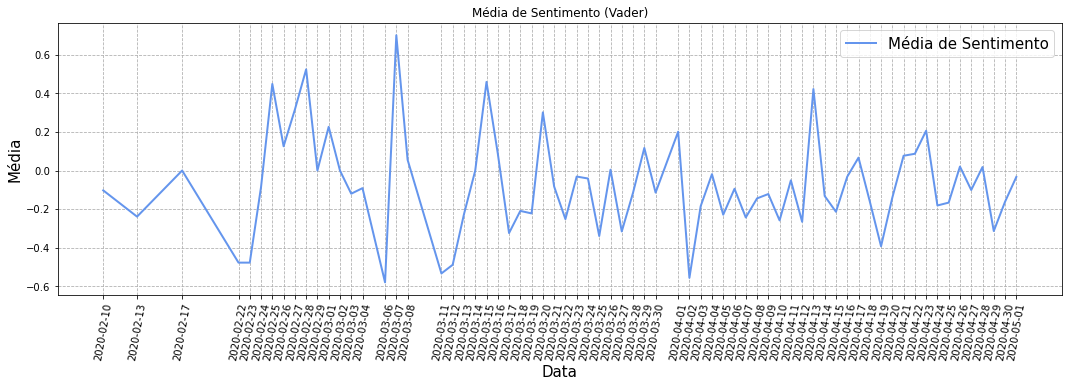

In [135]:
df_sentiment_mean = building_dates_df(df, 'score')

x = df_sentiment_mean.created_at
y = df_sentiment_mean.score_mean

label = 'Média de Sentimento'
color = 'cornflowerblue'
xLabel = 'Data'
yLabel = 'Média'
title = 'Média de Sentimento (Vader)'

generate_graphic(x, y, label, color, xLabel, yLabel, title)

Análises por período

In [136]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [137]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

,index,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,0,São Paulo,2020-02-25,1,0.00811,0.0,0,SP,1,0
1,2,São Paulo,2020-02-26,1,0.00811,0.0,0,SP,0,0
2,4,São Paulo,2020-02-27,1,0.00811,0.0,0,SP,0,0
3,6,São Paulo,2020-02-28,2,0.01623,0.0,0,SP,1,0
4,8,São Paulo,2020-02-29,2,0.01623,0.0,0,SP,0,0


In [138]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-02-25


In [139]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-03-17


Datas relevantes:

- Data do primeiro caso: 25/02/2020
- Data da primeira morte: 17/03/2020


- Data do primeiro decreto de medidas restritivas (Governador): 24/03/2020 a 07/04/2020
- Data da segundo decreto do medidas restritivas (Governador): 08/03/2020 a 22/04/2020
- Data da terceiro decreto do medidas restritivas (Governador): 23/04/2020 a 10/05/2020

**Análises - Datas de medidas restritivas - Antes e Depois a Primeira Medida**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 23/03/2020)**

In [140]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-23 23:59:59"')
len(df1_periodo1)

142

**Média de sentimentos no segundo intervalo (24/03/2020 a 01/05/2020)**

In [141]:
df1_periodo2 = df.query('created_at >= "2020-03-24 00:00:00" and created_at <= "2020-04-07 23:59:59"')
len(df1_periodo2)

98

Gráfico - Média Valores

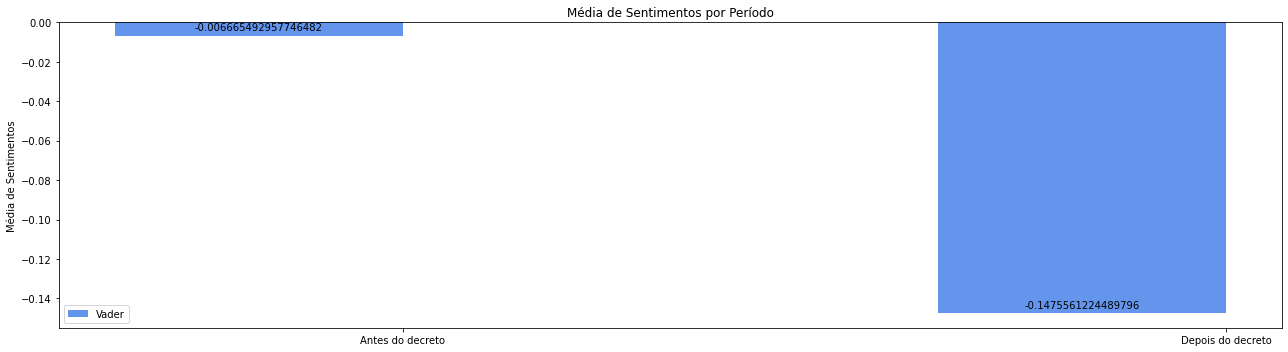

In [142]:
labels = ['Antes do decreto', 'Depois do decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

**Análises - Datas de medidas restritivas - Por períodos de decretos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 23/03/2020)**

In [143]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-23 23:59:59"')
len(df1_periodo1)

142

**Média de sentimentos no segundo intervalo (24/03/2020 a 22/04/2020)**

In [144]:
df1_periodo2 = df.query('created_at >= "2020-03-24 00:00:00" and created_at <= "2020-04-22 23:59:59"')
len(df1_periodo2)

376

**Média de sentimentos no terceiro intervalo (23/04/2020 a 01/05/2020)**

In [145]:
df1_periodo3 = df.query('created_at >= "2020-04-23 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo3)

117

Gráfico - Média Valores

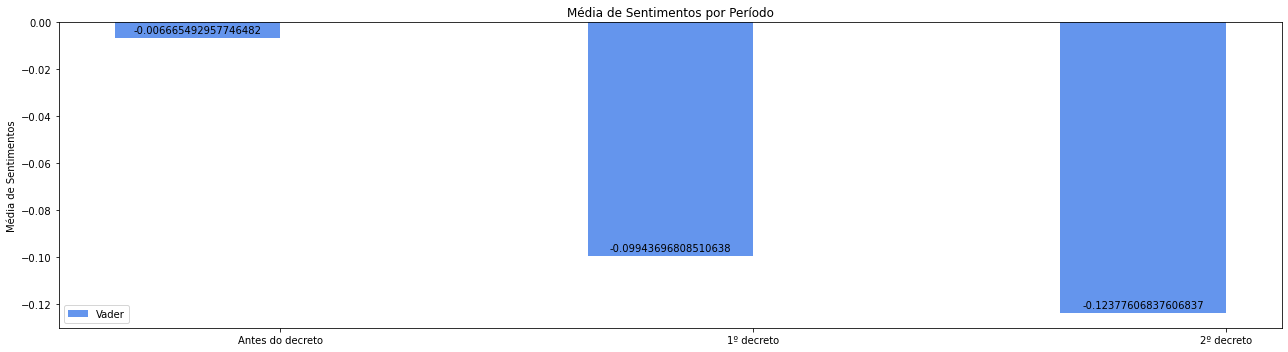

In [146]:
labels = ['Antes do decreto', '1º decreto', '2º decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score']), mean(df1_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

**Análises - Marcos relevantes de casos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 24/02/2020)**

In [147]:
df2_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-02-24 23:59:59"')
len(df2_periodo1)

12

**Média de sentimentos no segundo intervalo (25/02/2020 a 16/03/2020)**

In [148]:
df2_periodo2 = df.query('created_at >= "2020-02-25 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df2_periodo2)

94

**Média de sentimentos no terceiro intervalo (17/03/2020 a 01/05/2020)**

In [149]:
df2_periodo3 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df2_periodo3)

529

Gráfico

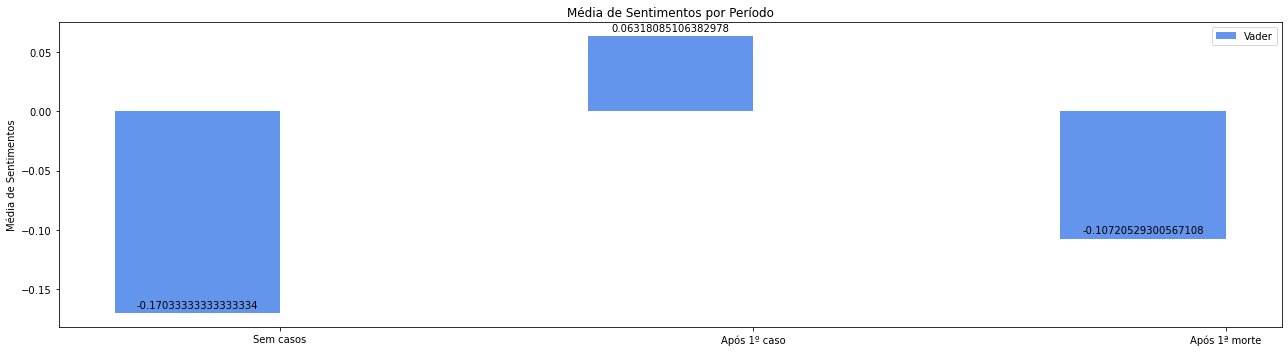

In [150]:
labels = ['Sem casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df2_periodo1['score']), mean(df2_periodo2['score']), mean(df2_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

Fontes:
-  SP contra o novo coronavírus - https://www.saopaulo.sp.gov.br/coronavirus/quarentena/